<a href="https://colab.research.google.com/github/HrithikNambiar/Visual-Hierarchy-based-fMRI-decoding/blob/main/Model_Kay_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import os
os.chdir('/content/drive/MyDrive/NMA-Algonauts') #HOMEPATH

# Data loading and set-up

In [ ]:
fname = "kay_labels.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/r638s/download
fname = "kay_labels_val.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/yqb3e/download
fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

In [ ]:
with np.load(fname) as dobj:
    dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')


`labels` is a 4 by stim array of class names:  
- row 3 has the labels predicted by a deep neural network (DNN) trained on Imagenet
- rows 0-2 correspond to different levels of the wordnet hierarchy for the DNN predictions

In [ ]:
print(labels[:,:4])

[['artifact' 'entity' 'animal' 'animal']
 ['instrumentality' 'round shape' 'vertebrate' 'vertebrate']
 ['equipment' 'sphere' 'mammal' 'amphibian']
 ['croquet ball' 'bubble' 'komondor' 'tailed frog']]


In [ ]:
print(dat.keys())

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


`dat` has the following fields:  
- `stimuli`: stim x i x j array of grayscale stimulus images
- `stimuli_test`: stim x i x j array of grayscale stimulus images in the test set  
- `responses`: stim x voxel array of z-scored BOLD response amplitude
- `responses_test`:  stim x voxel array of z-scored BOLD response amplitude in the test set  
- `roi`: array of voxel labels
- `roi_names`: array of names corresponding to voxel labels

In [ ]:
print(dat["stimuli"].shape)

(1750, 128, 128)


In [ ]:
print(dat["responses"].shape)

(1750, 8428)


In [ ]:
dat['responses']

array([[ 0.53109303, -0.1711666 , -2.18185285, ..., -0.08087291,
        -0.07181383, -1.14688391],
       [-0.37951583, -1.57913894, -1.52400553, ..., -0.11304473,
        -1.71730024,  1.17662354],
       [ 0.99324019,  1.1198156 ,  1.24312508, ..., -0.11032425,
        -1.38603068, -0.24259401],
       ...,
       [ 0.07942947, -0.8660068 , -1.40801776, ..., -0.97090844,
        -0.42258693,  1.59369111],
       [ 0.18489915, -0.06251201,  0.00356126, ...,  1.31298164,
         0.76796059,  0.30288753],
       [ 0.23190455, -0.59618648,  1.12224124, ...,  1.84459492,
        -1.26185295, -0.28723873]])

This is the number of voxels in each ROI. Note that `"Other"` voxels have been removed from this version of the dataset:

In [ ]:
dict(zip(dat["roi_names"], np.bincount(dat["roi"])))

{'LatOcc': 928,
 'Other': 0,
 'V1': 1294,
 'V2': 2083,
 'V3': 1790,
 'V3A': 484,
 'V3B': 314,
 'V4': 1535}

Each stimulus is a 128 x 128 grayscale array:

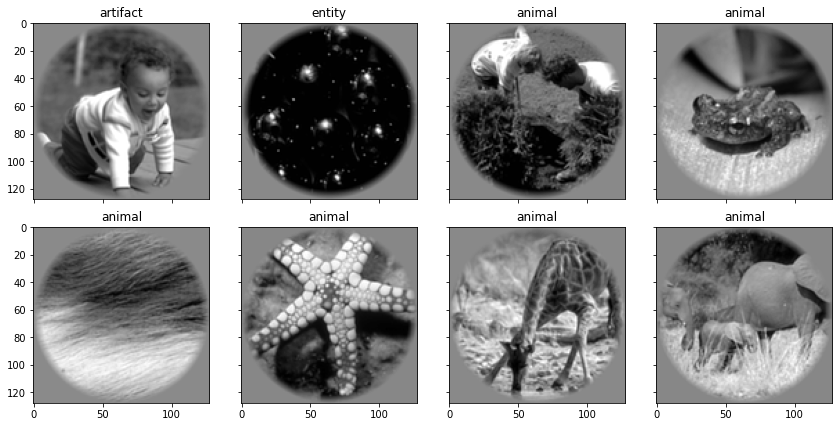

In [ ]:
f, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for ax, im, lbl in zip(axs.flat, dat["stimuli"], labels[0,:]):
  ax.imshow(im, cmap="gray")
  ax.set_title(lbl)
f.tight_layout()

Each stimulus is associated with a pattern of BOLD response across voxels in visual cortex:

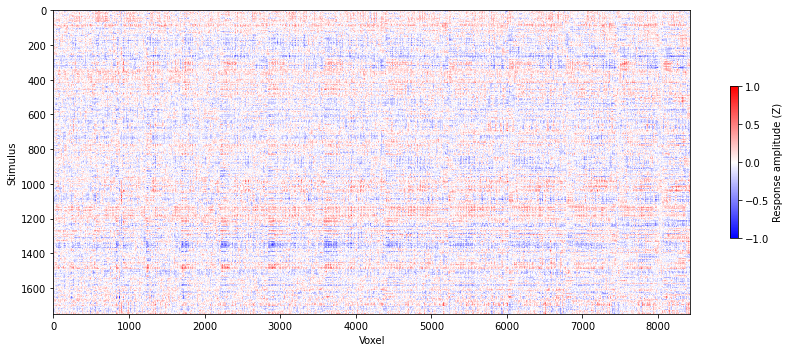

In [ ]:
f, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(dat["responses"], aspect="auto", vmin=-1, vmax=1, cmap="bwr")
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
f.tight_layout()

The training/validation splits from the original paper are retained, so the 120 test stimuli and responses are in separate data structures:

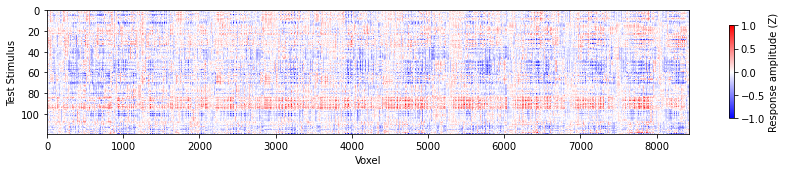

In [ ]:
f, ax = plt.subplots(figsize=(12, 2.5))
ax.set(xlabel="Voxel", ylabel="Test Stimulus")
heatmap = ax.imshow(dat["responses_test"], aspect="auto", vmin=-1, vmax=1, cmap="bwr")
f.colorbar(heatmap, shrink=.75, label="Response amplitude (Z)")
f.tight_layout()

# Pytorch

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, transforms, models

import time
from tqdm.notebook import tqdm
import random

1. Divide classes into Animal, artifacts and others
2. Apply regularization techniques if overfitting happens even using 3(animal,artifact,others) classes
3. Seperate each ROI's input and concat later stage (according to visual processing hierarchy of our brain) and compare with model using all input at the same time
4. Check if ROI input can be provided at different stages according to the hierarchical order. 


In [ ]:
stri, cnt = np.unique(labels[0,:],return_counts=True)
print(stri,cnt)

stri, cnt = np.unique(val_labels[0,:],return_counts=True)
print(stri,cnt)

['animal' 'artifact' 'entity' 'fruit' 'fungus' 'geological formation'
 'person' 'plant'] [589 812  72  77   5 192   2   1]
['animal' 'artifact' 'entity' 'fruit' 'fungus' 'geological formation'] [54 50  4  1  1 10]


In [ ]:
dat['responses'].shape

(1750, 8428)

In [ ]:
dat['stimuli'].shape

(1750, 128, 128)

In [ ]:
# Training dataset
class train_dataset(Dataset): 
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def __len__(self):
        return len(self.X_train)
    
    def __getitem__(self, idx): 
        X_train = torch.from_numpy(self.X_train[idx]).type(torch.FloatTensor)
        
        y_train = torch.from_numpy(self.y_train[idx]).type(torch.LongTensor)

        return X_train, y_train
    
# Test dataset
class test_dataset(Dataset): 
    def __init__(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        
    def __len__(self):
        return len(self.X_test)
    
    def __getitem__(self, idx): 
        X_test = torch.from_numpy(self.X_test[idx]).type(torch.FloatTensor)
        
        y_test = torch.from_numpy(self.y_test[idx]).type(torch.LongTensor)
        
        return X_test, y_test

# setting up - 3 classes and 2 classes

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()
y_train = le.fit_transform(labels[0,:]).reshape(-1,1)
y_test = le.transform(val_labels[0,:]).reshape(-1,1)

In [ ]:
#Have to convert other categories to 'Others'
# Here, Animal = 0, Artifact = 1, so we can set others to category 2
print('Train set before changing : ' + str(np.unique(y_train, return_counts= True)))
print('Test set before changing : ' + str(np.unique(y_test, return_counts= True)))

#new array
y3_train = np.zeros_like(y_train)
y3_test = np.zeros_like(y_test)

for idx,i in enumerate(y_train): #Train set
  if i[0] == 0:
    y3_train[idx] = 0
  if i[0] == 1:
    y3_train[idx] = 1
  if i[0]>=2:
    y3_train[idx] = 2

for idx,i in enumerate(y_test): #Test set
  if i[0] == 0:
    y3_test[idx] = 0
  if i[0] == 1:
    y3_test[idx] = 1
  if i[0]>=2:
    y3_test[idx] = 2

print('Train set after changing : ' + str(np.unique(y3_train, return_counts= True)))
print('Test set after changing : ' + str(np.unique(y3_test, return_counts= True)))

Train set before changing : (array([0, 1, 2, 3, 4, 5, 6, 7]), array([589, 812,  72,  77,   5, 192,   2,   1]))
Test set before changing : (array([0, 1, 2, 3, 4, 5]), array([54, 50,  4,  1,  1, 10]))
Train set after changing : (array([0, 1, 2]), array([589, 812, 349]))
Test set after changing : (array([0, 1, 2]), array([54, 50, 16]))


convert to 3 classes - animal,artifact and others

In [ ]:
y3_train.shape, y3_test.shape

((1750, 1), (120, 1))

In [ ]:
print(dict(zip(dat["roi_names"], np.bincount(dat["roi"]))))
print(np.unique(dat["roi"],return_counts=True))

{'Other': 0, 'V1': 1294, 'V2': 2083, 'V3': 1790, 'V3A': 484, 'V3B': 314, 'V4': 1535, 'LatOcc': 928}
(array([1, 2, 3, 4, 5, 6, 7]), array([1294, 2083, 1790,  484,  314, 1535,  928]))


2 classes - animal,artifact

In [ ]:
y2_train = y3_train[np.where(y3_train!=2)[0].tolist()]
y2_test = y3_test[np.where(y3_test!=2)[0].tolist()]
data2 = dat['responses'][np.where(y3_train!=2)[0],:]
val_data2 = dat['responses_test'][np.where(y3_test!=2)[0],:]

print(y2_train.shape, y2_test.shape, data2.shape, val_data2.shape)

(1401, 1) (104, 1) (1401, 8428) (104, 8428)


In [ ]:
sti_data2 = dat['stimuli'][np.where(y3_train!=2)[0],:]
sti_val_data2 = dat['stimuli_test'][np.where(y3_test!=2)[0],:]
print(sti_data2.shape,sti_val_data2.shape)

(1401, 128, 128) (104, 128, 128)


# 8 classes , model with dropout

In [ ]:
class Net(nn.Module):
    def __init__(self,in_size,n_hidden1,n_hidden2,out_size,p=0):
        super(Net,self).__init__()
        self.drop=nn.Dropout(p=p)
        self.linear1=nn.Linear(in_size,n_hidden1)
        nn.init.kaiming_uniform_(self.linear1.weight,nonlinearity='relu')
        self.linear2=nn.Linear(n_hidden1,n_hidden2)
        nn.init.kaiming_uniform_(self.linear1.weight,nonlinearity='relu')
        self.linear3=nn.Linear(n_hidden2,n_hidden2)
        nn.init.kaiming_uniform_(self.linear3.weight,nonlinearity='relu')
        self.linear4=nn.Linear(n_hidden2,out_size)
        
    def forward(self,x):
        x=F.relu(self.linear1(x))
        x=self.drop(x)
        x=F.relu(self.linear2(x))
        x=self.drop(x)
        x=F.relu(self.linear3(x))
        x=self.drop(x)
        x=self.linear4(x)
        return x

In [ ]:
train_loader = DataLoader(train_dataset(dat['responses'],y_train), batch_size = 32, shuffle = True, drop_last = True, num_workers = 2)
test_loader = DataLoader(test_dataset(dat['responses_test'],y_test), batch_size = 32, shuffle = True, drop_last = True, num_workers = 2)

In [ ]:
model = Net(len(dat['responses'][1]),4000,1000,len(np.unique(labels[0,:])),p=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.1, nesterov=True)
# criterion =nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss()
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.3, patience = 10)

train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

n_epochs=100

for epoch in range(0,n_epochs):
    print(f'Starting epoch {epoch+1}')
    model.train()
    count =1
    total=0
    train_acc =0
    train_correct=0
    train_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        y=y.reshape(32,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
        
        loss = criterion(yhat, y)
        train_loss +=loss.item()
        
        loss.backward()
        optimizer.step()

        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        train_correct += (pred == y).sum().item()
        count+=1

    train_loss /= count
    train_acc = 100 * train_correct / total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    if epoch%5==0:
      print(f'Train_acc : {round(train_acc,3)}')
      print(f'Train_loss : {round(train_loss,3)}')
    
    #############################################################
    #test
    model.eval()
    total =0
    test_correct = 0
    test_loss =0
    test_acc=0
    count =1

    with torch.no_grad():
      for x,y in test_loader:
        y=y.reshape(32,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
      
        loss = criterion(yhat, y)
        test_loss +=loss.item()
        
        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        test_correct += (pred == y).sum().item()
        count+=1
        
      test_loss /= count
      test_acc = 100 * test_correct / total
      test_acc_list.append(test_acc)
      test_loss_list.append(loss.item())
    
      if epoch%5==0:
        print(f'Test_acc : {round(test_acc,3)}')
        print(f'Test_loss : {round(test_loss,3)}') 
        print("----------------------------")

Starting epoch 1
Train_acc : 41.204
Train_loss : 32.385
Test_acc : 42.708
Test_loss : 0.847
----------------------------
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Train_acc : 46.123
Train_loss : 1.27
Test_acc : 41.667
Test_loss : 0.887
----------------------------
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Train_acc : 46.238
Train_loss : 1.251
Test_acc : 42.708
Test_loss : 0.865
----------------------------
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Train_acc : 46.759
Train_loss : 1.253
Test_acc : 43.75
Test_loss : 0.853
----------------------------
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Train_acc : 46.181
Train_loss : 1.271
Test_acc : 41.667
Test_loss : 0.878
----------------------------
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Train_acc : 46.354
Train_lo

SGD optimizer

In [ ]:
model = Net(len(dat['responses'][1]),4000,1000,len(np.unique(labels[0,:])),p=0.3)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.1, nesterov=True)
criterion =nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.3, patience = 10)

train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

n_epochs=100

for epoch in range(0,n_epochs):
    print(f'Starting epoch {epoch+1}')
    model.train()
    count =1
    total=0
    train_acc =0
    train_correct=0
    train_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        y=y.reshape(32,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
        
        loss = criterion(yhat, y)
        train_loss +=loss.item()
        
        loss.backward()
        optimizer.step()

        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        train_correct += (pred == y).sum().item()
        count+=1

    train_loss /= count
    train_acc = 100 * train_correct / total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    if epoch%5==0:
      print(f'Train_acc : {round(train_acc,3)}')
      print(f'Train_loss : {round(train_loss,3)}')
    
    #############################################################
    #test
    model.eval()
    total =0
    test_correct = 0
    test_loss =0
    test_acc=0
    count =1

    with torch.no_grad():
      for x,y in test_loader:
        y=y.reshape(32,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
      
        loss = criterion(yhat, y)
        test_loss +=loss.item()
        
        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        test_correct += (pred == y).sum().item()
        count+=1
        
      test_loss /= count
      test_acc = 100 * test_correct / total
      test_acc_list.append(test_acc)
      test_loss_list.append(loss.item())
    
      if epoch%5==0:
        print(f'Test_acc : {round(test_acc,3)}')
        print(f'Test_loss : {round(test_loss,3)}') 
        print("----------------------------")

Starting epoch 1
Train_acc : 41.088
Train_loss : 1.505
Test_acc : 39.583
Test_loss : 1.183
----------------------------
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Train_acc : 48.785
Train_loss : 1.23
Test_acc : 39.583
Test_loss : 1.093
----------------------------
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Train_acc : 52.199
Train_loss : 1.164
Test_acc : 38.542
Test_loss : 1.089
----------------------------
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Train_acc : 58.218
Train_loss : 1.08
Test_acc : 42.708
Test_loss : 1.059
----------------------------
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Train_acc : 63.889
Train_loss : 0.983
Test_acc : 45.833
Test_loss : 1.052
----------------------------
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Train_acc : 65.567
Train_los

PLOTS

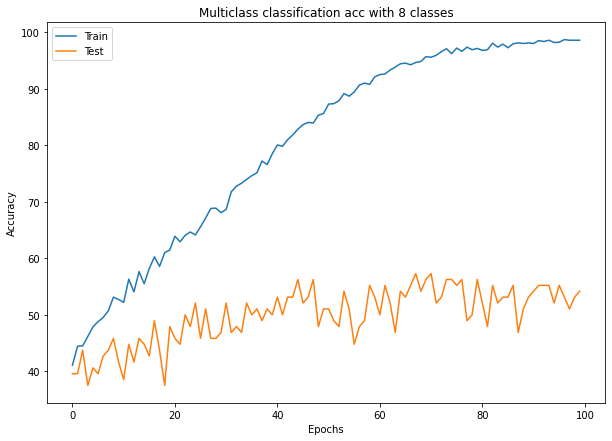

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Multiclass classification acc with 8 classes')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.legend(['Train','Test'])
plt.show()

# 3 classes - model

In [ ]:
train_loader = DataLoader(train_dataset(dat['responses'],y3_train), batch_size = 32, shuffle = True, drop_last = True)
test_loader = DataLoader(test_dataset(dat['responses_test'],y3_test), batch_size = 32, shuffle = True, drop_last = True)

In [ ]:
model = Net(len(dat['responses'][1]),4000,1000,len(np.unique(y3_train)),p=0.45)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01) -- around 45 on test
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.1, nesterov=True)
criterion = torch.nn.CrossEntropyLoss()

train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

n_epochs=40

for epoch in range(0,n_epochs):
    print(f'Starting epoch {epoch+1}')
    model.train()
    count =1
    total=0
    train_acc =0
    train_correct=0
    train_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        y=y.reshape(32,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
        
        loss = criterion(yhat, y)
        train_loss +=loss.item()
        
        loss.backward()
        optimizer.step()

        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        train_correct += (pred == y).sum().item()
        count+=1

    train_loss /= count
    train_acc = 100 * train_correct / total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    if epoch%5==0:
      print(f'Train_acc : {round(train_acc,3)}')
      print(f'Train_loss : {round(train_loss,3)}')
    
    #############################################################
    #test
    model.eval()
    total =0
    test_correct = 0
    test_loss =0
    test_acc=0
    count =1

    with torch.no_grad():
      for x,y in test_loader:
        y=y.reshape(32,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
      
        loss = criterion(yhat, y)
        test_loss +=loss.item()
        
        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        test_correct += (pred == y).sum().item()
        count+=1
        
      test_loss /= count
      test_acc = 100 * test_correct / total
      test_acc_list.append(test_acc)
      test_loss_list.append(loss.item())
    
      if epoch%5==0:
        print(f'Test_acc : {round(test_acc,3)}')
        print(f'Test_loss : {round(test_loss,3)}') 
        print("----------------------------")

NameError: ignored

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Multiclass classification acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.legend(['Train','Test'])
plt.show()

# Hierachical Model

In [ ]:
# Building model
class DNNmodel(nn.Module):
    def __init__(self):
        super(DNNmodel, self).__init__()

        #V1
        self.roi1 = nn.Sequential(
            nn.Linear(1294,400),      #Output dim has to be set
            # nn.BatchNorm1d(400),
            nn.ReLU()
        )

        #V2
        self.roi2 = nn.Sequential(
            nn.Linear(2083+200,400),      #Output dim has to be set
            # nn.BatchNorm1d(500),
            nn.ReLU()
        )

        #V3
        self.roi3 = nn.Sequential(
            nn.Linear(1790+200,400),      #Output dim has to be set
            # nn.BatchNorm1d(450),
            nn.ReLU()
        )

        #V3A
        self.roi4 = nn.Sequential(
            nn.Linear(484+200,400),     #Output dim has to be set
            # nn.BatchNorm1d(100),
            nn.ReLU()
        )

        #V3B
        self.roi5 = nn.Sequential(
            nn.Linear(314+200,400),     #Output dim has to be set
            # nn.BatchNorm1d(80),
            nn.ReLU()
        )

        #V4
        self.roi6 = nn.Sequential(
            nn.Linear(1535+200,400),      #Output dim has to be set
            # nn.BatchNorm1d(400),
            nn.ReLU()
        )

        #LatOcc
        self.roi7 = nn.Sequential(
            nn.Linear(928+200,400),     #Output dim has to be set
            # nn.BatchNorm1d(200),
            nn.ReLU()
        )

        self.fc1 = nn.Linear(400,200)
        self.fc2 = nn.Linear(400,200)
        self.fc3 = nn.Linear(400,200)
        self.fc4 = nn.Linear(400,200)
        self.fc5 = nn.Linear(400,200)
        self.fc6 = nn.Linear(400,200)
        self.fc7 = nn.Linear(400,300)


        self.classifier1 = nn.Linear(300,200)      #Input dim has to be set. Output would be 3 classes (Animal, Artifact, Others)
        self.classifier2 = nn.Linear(200,3)
        self.do = nn.Dropout(0.25)

    def forward(self, input):

        x1 = input[:,np.where(dat["roi"]==1)[0].tolist()]
        x2 = input[:,np.where(dat["roi"]==2)[0].tolist()]
        x3 = input[:,np.where(dat["roi"]==3)[0].tolist()]
        x4 = input[:,np.where(dat["roi"]==4)[0].tolist()]
        x5 = input[:,np.where(dat["roi"]==5)[0].tolist()]
        x6 = input[:,np.where(dat["roi"]==6)[0].tolist()]
        x7 = input[:,np.where(dat["roi"]==7)[0].tolist()]

        # print(x1.shape)
        # print(x2.shape)
        # print(x3.shape)
        # print(x4.shape)
        # print(x5.shape)
        # print(x6.shape)
        # print(x7.shape)

        x1 = self.roi1(x1)
        x1 =  self.fc1(x1)
        
        x2 = torch.cat((x1,x2),dim=1)
        x2 = self.roi2(x2)
        x2= self.fc2(x2)
        
        x3 = torch.cat((x2,x3),dim=1)
        x3 = self.roi3(x3)
        x3 = self.fc3(x3)

        x4 = torch.cat((x3,x4),dim=1)
        x4 = self.roi4(x4)
        x4 = self.fc4(x4)

        x5 = torch.cat((x4,x5),dim=1)
        x5 = self.roi5(x5)
        x5 = self.fc5(x5)

        x6 = torch.cat((x5,x6),dim=1)
        x6 = self.roi6(x6)
        x6 = self.fc6(x6)

        x7 = torch.cat((x6,x7),dim=1)
        x7 = self.roi7(x7)
        x7 = self.fc7(x7)


        # print(x1.shape)
        # print(x2.shape)
        # print(x3.shape)
        # print(x4.shape)
        # print(x5.shape)
        # print(x6.shape)
        # print(x7.shape)


        # x1 = x1.view(x1.size(0),-1)
        # x2 = x2.view(x2.size(0),-1)
        # x3 = x3.view(x3.size(0),-1)
        # x4 = x4.view(x4.size(0),-1)
        # x5 = x5.view(x5.size(0),-1)
        # x6 = x6.view(x6.size(0),-1)
        # x7 = x7.view(x7.size(0),-1)


        # x = torch.cat((x1,x2,x3,x4,x5,x6,x7), dim=1)
        # print(x.shape)
        x = F.relu(self.classifier1(x7))
        x = self.do(x)
        out = self.classifier2(x)

        # print(out.shape)
        return out
    
    def weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # He initialization for ReLU
                nn.init.xavier_uniform_(m.weight)
                # Bias initialization
                nn.init.normal_(m.bias, std=0.01)

3 class

In [ ]:
train_loader = DataLoader(train_dataset(dat['responses'],y3_train), batch_size = 32, shuffle = True, drop_last = True)
test_loader = DataLoader(test_dataset(dat['responses_test'],y3_test), batch_size = 32, shuffle = True, drop_last = True)

In [ ]:
# model = Net(len(dat['responses'][1]),4000,1000,len(np.unique(new_y_train)),p=0.3)

model = DNNmodel()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.1, nesterov=True)
criterion = torch.nn.CrossEntropyLoss()

train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

n_epochs=200

for epoch in range(0,n_epochs):
    print(f'Starting epoch {epoch+1}')
    model.train()
    count =1
    total=0
    train_acc =0
    train_correct=0
    train_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        y=y.reshape(32,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
        
        loss = criterion(yhat, y)
        train_loss +=loss.item()
        
        loss.backward()
        optimizer.step()

        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        train_correct += (pred == y).sum().item()
        count+=1

    train_loss /= count
    train_acc = 100 * train_correct / total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    if epoch%10==0:
      print(f'Train_acc : {round(train_acc,3)}')
      print(f'Train_loss : {round(train_loss,3)}')
    
    #############################################################
    #test
    model.eval()
    total =0
    test_correct = 0
    test_loss =0
    test_acc=0
    count =1

    with torch.no_grad():
      for x,y in test_loader:
        y=y.reshape(32,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
      
        loss = criterion(yhat, y)
        test_loss +=loss.item()
        
        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        test_correct += (pred == y).sum().item()
        count+=1
        
      test_loss /= count
      test_acc = 100 * test_correct / total
      test_acc_list.append(test_acc)
      test_loss_list.append(loss.item())
    
      if epoch%10==0:
        print(f'Test_acc : {round(test_acc,3)}')
        print(f'Test_loss : {round(test_loss,3)}') 
        print("----------------------------")

RuntimeError: ignored

2 class

In [ ]:
train_loader = DataLoader(train_dataset(data2,y2_train), batch_size = 32, shuffle = True, drop_last = True)
test_loader = DataLoader(test_dataset(val_data2,y2_test), batch_size = 32, shuffle = True, drop_last = True)

In [ ]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=bfc72cf98adecad503242560f016e706ec882200b1d6c7db9c10a687b7c24003
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
# model = Net(len(dat['responses'][1]),4000,1000,len(np.unique(new_y_train)),p=0.3)

model = DNNmodel()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.1, nesterov=True)
criterion = torch.nn.CrossEntropyLoss()

train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

n_epochs=200

for epoch in range(0,n_epochs):
    print(f'Starting epoch {epoch+1}')
    model.train()
    count =1
    total=0
    train_acc =0
    train_correct=0
    train_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        y=y.reshape(32,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
        
        loss = criterion(yhat, y)
        train_loss +=loss.item()
        
        loss.backward()
        optimizer.step()

        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        train_correct += (pred == y).sum().item()
        count+=1

    train_loss /= count
    train_acc = 100 * train_correct / total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    if epoch%10==0:
      print(f'Train_acc : {round(train_acc,3)}')
      print(f'Train_loss : {round(train_loss,3)}')
    
    #############################################################
    #test
    model.eval()
    total =0
    test_correct = 0
    test_loss =0
    test_acc=0
    count =1

    with torch.no_grad():
      for x,y in test_loader:
        y=y.reshape(32,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
      
        loss = criterion(yhat, y)
        test_loss +=loss.item()
        
        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        test_correct += (pred == y).sum().item()
        count+=1
        
      test_loss /= count
      test_acc = 100 * test_correct / total
      test_acc_list.append(test_acc)
      test_loss_list.append(loss.item())
    
      if epoch%10==0:
        print(f'Test_acc : {round(test_acc,3)}')
        print(f'Test_loss : {round(test_loss,3)}') 
        print("----------------------------")

Starting epoch 1
Train_acc : 46.512
Train_loss : 0.679
Test_acc : 48.958
Test_loss : 0.522
----------------------------
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Train_acc : 58.43
Train_loss : 0.663
Test_acc : 50.0
Test_loss : 0.522
----------------------------
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Train_acc : 57.922
Train_loss : 0.654
Test_acc : 47.917
Test_loss : 0.529
----------------------------
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Train_acc : 58.721
Train_loss : 0.645
Test_acc : 45.833
Test_loss : 0.535
----------------------------
Starting epoch 32
Starting epoch 33
Starti

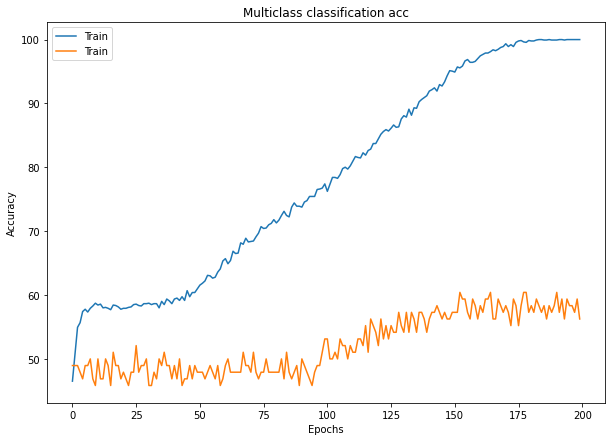

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Multiclass classification acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.legend(['Train','Train'])
plt.show()

# Ablation Study on V1,V2,V3

In [ ]:
# Building model
class DNNmodel(nn.Module):
    def __init__(self):
        super(DNNmodel, self).__init__()

        #V1
        self.roi1 = nn.Sequential(
            nn.Linear(1294,400),      #Output dim has to be set
            # nn.BatchNorm1d(400),
            nn.ReLU()
        )

        #V2
        self.roi2 = nn.Sequential(
            nn.Linear(2083,400), #nn.Linear(2083+200,400),      #Output dim has to be set
            # nn.BatchNorm1d(500),
            nn.ReLU()
        )

        #V3
        self.roi3 = nn.Sequential(
            nn.Linear(1790+200,400),      #Output dim has to be set
            # nn.BatchNorm1d(450),
            nn.ReLU()
        )

        #V3A
        self.roi4 = nn.Sequential(
            nn.Linear(484+200,400),     #Output dim has to be set
            # nn.BatchNorm1d(100),
            nn.ReLU()
        )

        #V3B
        self.roi5 = nn.Sequential(
            nn.Linear(314+200,400),     #Output dim has to be set
            # nn.BatchNorm1d(80),
            nn.ReLU()
        )

        #V4
        self.roi6 = nn.Sequential(
            nn.Linear(1535+200,400),      #Output dim has to be set
            # nn.BatchNorm1d(400),
            nn.ReLU()
        )

        #LatOcc
        self.roi7 = nn.Sequential(
            nn.Linear(928+200,400),     #Output dim has to be set
            # nn.BatchNorm1d(200),
            nn.ReLU()
        )

        self.fc1 = nn.Linear(400,200)
        self.fc2 = nn.Linear(400,200)
        self.fc3 = nn.Linear(400,200)
        self.fc4 = nn.Linear(400,200)
        self.fc5 = nn.Linear(400,200)
        self.fc6 = nn.Linear(400,200)
        self.fc7 = nn.Linear(400,300)


        self.classifier1 = nn.Linear(300,200)      #Input dim has to be set. Output would be 3 classes (Animal, Artifact, Others)
        self.classifier2 = nn.Linear(200,2)
        self.do = nn.Dropout(0.25)

    def forward(self, input):

        x1 = input[:,np.where(dat["roi"]==1)[0].tolist()]
        x2 = input[:,np.where(dat["roi"]==2)[0].tolist()]
        x3 = input[:,np.where(dat["roi"]==3)[0].tolist()]
        x4 = input[:,np.where(dat["roi"]==4)[0].tolist()]
        x5 = input[:,np.where(dat["roi"]==5)[0].tolist()]
        x6 = input[:,np.where(dat["roi"]==6)[0].tolist()]
        x7 = input[:,np.where(dat["roi"]==7)[0].tolist()]

        # print(x1.shape)
        # print(x2.shape)
        # print(x3.shape)
        # print(x4.shape)
        # print(x5.shape)
        # print(x6.shape)
        # print(x7.shape)

        # x1 = self.roi1(x1)
        # x1 = self.fc1(x1)
        
        # x2 = torch.cat((x1,x2),dim=1)
        x2 = self.roi2(x2)
        x2= self.fc2(x2)
        
        x3 = torch.cat((x1,x3),dim=1)
        x3 = self.roi3(x3)
        x3 = self.fc3(x3)

        x4 = torch.cat((x4,x2),dim=1)
        x4 = self.roi4(x4)
        x4 = self.fc4(x4)

        x5 = torch.cat((x4,x5),dim=1)
        x5 = self.roi5(x5)
        x5 = self.fc5(x5)

        x6 = torch.cat((x5,x6),dim=1)
        x6 = self.roi6(x6)
        x6 = self.fc6(x6)

        x7 = torch.cat((x6,x7),dim=1)
        x7 = self.roi7(x7)
        x7 = self.fc7(x7)


        # print(x1.shape)
        # print(x2.shape)
        # print(x3.shape)
        # print(x4.shape)
        # print(x5.shape)
        # print(x6.shape)
        # print(x7.shape)


        # x1 = x1.view(x1.size(0),-1)
        # x2 = x2.view(x2.size(0),-1)
        # x3 = x3.view(x3.size(0),-1)
        # x4 = x4.view(x4.size(0),-1)
        # x5 = x5.view(x5.size(0),-1)
        # x6 = x6.view(x6.size(0),-1)
        # x7 = x7.view(x7.size(0),-1)


        # x = torch.cat((x1,x2,x3,x4,x5,x6,x7), dim=1)
        # print(x.shape)
        x = F.relu(self.classifier1(x7))
        x = self.do(x)
        out = self.classifier2(x)

        # print(out.shape)
        return out
    
    def weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # He initialization for ReLU
                nn.init.xavier_uniform_(m.weight)
                # Bias initialization
                nn.init.normal_(m.bias, std=0.01)

In [ ]:
train_loader = DataLoader(train_dataset(data2,y2_train), batch_size = 32, shuffle = True, drop_last = True)
test_loader = DataLoader(test_dataset(val_data2,y2_test), batch_size = 32, shuffle = True, drop_last = True)

Results with V1 removed

In [ ]:
model = DNNmodel()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.1, nesterov=True)
criterion = torch.nn.CrossEntropyLoss()

train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

n_epochs=200

for epoch in range(0,n_epochs):
    print(f'Starting epoch {epoch+1}')
    model.train()
    count =1
    total=0
    train_acc =0
    train_correct=0
    train_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        y=y.reshape(32,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
        
        loss = criterion(yhat, y)
        train_loss +=loss.item()
        
        loss.backward()
        optimizer.step()

        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        train_correct += (pred == y).sum().item()
        count+=1

    train_loss /= count
    train_acc = 100 * train_correct / total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    if epoch%10==0:
      print(f'Train_acc : {round(train_acc,3)}')
      print(f'Train_loss : {round(train_loss,3)}')
    
    #############################################################
    #test
    model.eval()
    total =0
    test_correct = 0
    test_loss =0
    test_acc=0
    count =1

    with torch.no_grad():
      for x,y in test_loader:
        y=y.reshape(32,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
      
        loss = criterion(yhat, y)
        test_loss +=loss.item()
        
        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        test_correct += (pred == y).sum().item()
        count+=1
        
      test_loss /= count
      test_acc = 100 * test_correct / total
      test_acc_list.append(test_acc)
      test_loss_list.append(loss.item())
    
      if epoch%10==0:
        print(f'Test_acc : {round(test_acc,3)}')
        print(f'Test_loss : {round(test_loss,3)}') 
        print("----------------------------")

Starting epoch 1
Train_acc : 52.98
Train_loss : 0.676
Test_acc : 52.083
Test_loss : 0.52
----------------------------
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Train_acc : 57.922
Train_loss : 0.662
Test_acc : 46.875
Test_loss : 0.523
----------------------------
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Train_acc : 58.43
Train_loss : 0.651
Test_acc : 46.875
Test_loss : 0.527
----------------------------
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Train_acc : 58.794
Train_loss : 0.64
Test_acc : 47.917
Test_loss : 0.524
----------------------------
Starting epoch 32
Starting epoch 33
Startin

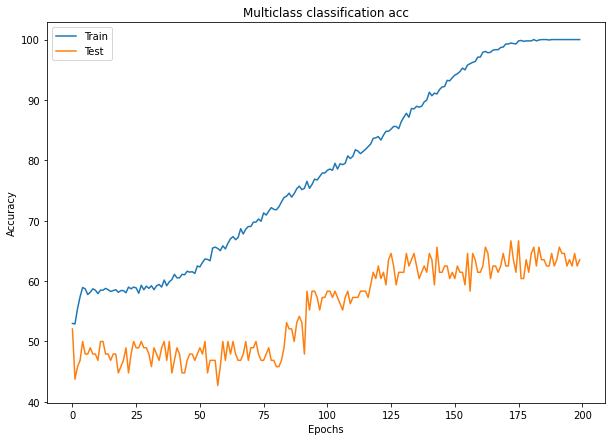

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Multiclass classification acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.legend(['Train','Test'])
plt.show()

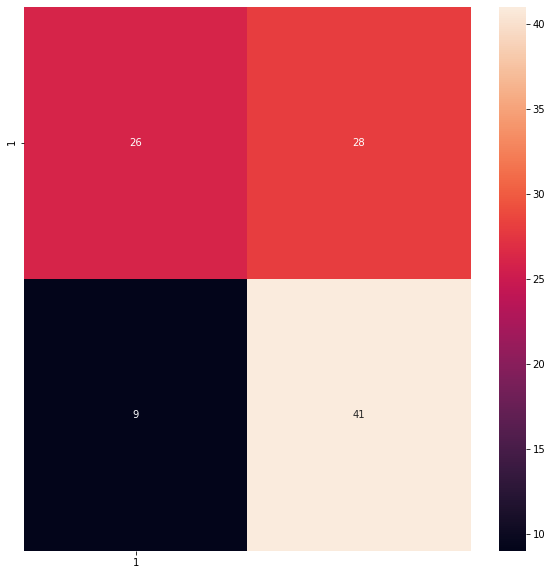

In [ ]:
import seaborn as sns
test_feature = torch.from_numpy(val_data2).type(torch.FloatTensor).to(device)
y_pred = model(test_feature)
_, pred = torch.max(y_pred, 1)
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y2_test,pred.cpu().detach().numpy())

plt.figure(figsize=(10,10,))
sns.heatmap(conf,  annot=True, xticklabels = np.unique(y2_train[0,:])[:3]
            ,yticklabels = np.unique(y2_train[0,:])[:2])

Results with V2 removed

In [ ]:
model = DNNmodel()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.1, nesterov=True)
criterion = torch.nn.CrossEntropyLoss()

train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

n_epochs=200

for epoch in range(0,n_epochs):
    print(f'Starting epoch {epoch+1}')
    model.train()
    count =1
    total=0
    train_acc =0
    train_correct=0
    train_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        y=y.reshape(32,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
        
        loss = criterion(yhat, y)
        train_loss +=loss.item()
        
        loss.backward()
        optimizer.step()

        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        train_correct += (pred == y).sum().item()
        count+=1

    train_loss /= count
    train_acc = 100 * train_correct / total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    if epoch%10==0:
      print(f'Train_acc : {round(train_acc,3)}')
      print(f'Train_loss : {round(train_loss,3)}')
    
    #############################################################
    #test
    model.eval()
    total =0
    test_correct = 0
    test_loss =0
    test_acc=0
    count =1

    with torch.no_grad():
      for x,y in test_loader:
        y=y.reshape(32,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
      
        loss = criterion(yhat, y)
        test_loss +=loss.item()
        
        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        test_correct += (pred == y).sum().item()
        count+=1
        
      test_loss /= count
      test_acc = 100 * test_correct / total
      test_acc_list.append(test_acc)
      test_loss_list.append(loss.item())
    
      if epoch%10==0:
        print(f'Test_acc : {round(test_acc,3)}')
        print(f'Test_loss : {round(test_loss,3)}') 
        print("----------------------------")

Starting epoch 1
Train_acc : 56.977
Train_loss : 0.67
Test_acc : 46.875
Test_loss : 0.527
----------------------------
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Train_acc : 57.922
Train_loss : 0.659
Test_acc : 46.875
Test_loss : 0.531
----------------------------
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Train_acc : 57.849
Train_loss : 0.651
Test_acc : 51.042
Test_loss : 0.524
----------------------------
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Train_acc : 58.576
Train_loss : 0.642
Test_acc : 47.917
Test_loss : 0.531
----------------------------
Starting epoch 32
Starting epoch 33
Star

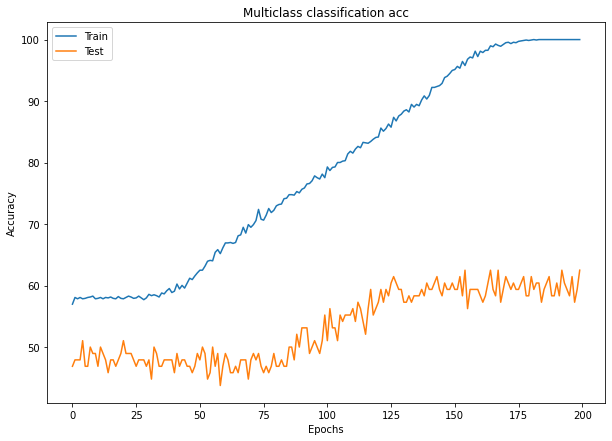

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Multiclass classification acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.legend(['Train','Test'])
plt.show()

V4 removed

In [ ]:
model = DNNmodel()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.1, nesterov=True)
criterion = torch.nn.CrossEntropyLoss()

train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

n_epochs=200

for epoch in range(0,n_epochs):
    print(f'Starting epoch {epoch+1}')
    model.train()
    count =1
    total=0
    train_acc =0
    train_correct=0
    train_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        y=y.reshape(32,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
        
        loss = criterion(yhat, y)
        train_loss +=loss.item()
        
        loss.backward()
        optimizer.step()

        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        train_correct += (pred == y).sum().item()
        count+=1

    train_loss /= count
    train_acc = 100 * train_correct / total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    if epoch%10==0:
      print(f'Train_acc : {round(train_acc,3)}')
      print(f'Train_loss : {round(train_loss,3)}')
    
    #############################################################
    #test
    model.eval()
    total =0
    test_correct = 0
    test_loss =0
    test_acc=0
    count =1

    with torch.no_grad():
      for x,y in test_loader:
        y=y.reshape(32,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
      
        loss = criterion(yhat, y)
        test_loss +=loss.item()
        
        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        test_correct += (pred == y).sum().item()
        count+=1
        
      test_loss /= count
      test_acc = 100 * test_correct / total
      test_acc_list.append(test_acc)
      test_loss_list.append(loss.item())
    
      if epoch%10==0:
        print(f'Test_acc : {round(test_acc,3)}')
        print(f'Test_loss : {round(test_loss,3)}') 
        print("----------------------------")

Starting epoch 1
Train_acc : 55.959
Train_loss : 0.671
Test_acc : 48.958
Test_loss : 0.522
----------------------------
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Train_acc : 58.14
Train_loss : 0.662
Test_acc : 48.958
Test_loss : 0.524
----------------------------
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Train_acc : 57.776
Train_loss : 0.658
Test_acc : 46.875
Test_loss : 0.527
----------------------------
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Train_acc : 57.849
Train_loss : 0.652
Test_acc : 50.0
Test_loss : 0.522
----------------------------
Starting epoch 32
Starting epoch 33
Starti

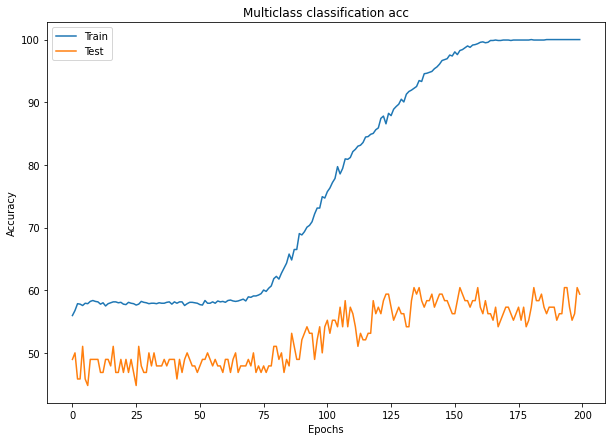

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Multiclass classification acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.legend(['Train','Test'])
plt.show()

V3

In [ ]:
model = DNNmodel()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.1, nesterov=True)
criterion = torch.nn.CrossEntropyLoss()

train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

n_epochs=200

for epoch in range(0,n_epochs):
    print(f'Starting epoch {epoch+1}')
    model.train()
    count =1
    total=0
    train_acc =0
    train_correct=0
    train_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        y=y.reshape(32,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
        
        loss = criterion(yhat, y)
        train_loss +=loss.item()
        
        loss.backward()
        optimizer.step()

        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        train_correct += (pred == y).sum().item()
        count+=1

    train_loss /= count
    train_acc = 100 * train_correct / total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    if epoch%10==0:
      print(f'Train_acc : {round(train_acc,3)}')
      print(f'Train_loss : {round(train_loss,3)}')
    
    #############################################################
    #test
    model.eval()
    total =0
    test_correct = 0
    test_loss =0
    test_acc=0
    count =1

    with torch.no_grad():
      for x,y in test_loader:
        y=y.reshape(32,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
      
        loss = criterion(yhat, y)
        test_loss +=loss.item()
        
        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        test_correct += (pred == y).sum().item()
        count+=1
        
      test_loss /= count
      test_acc = 100 * test_correct / total
      test_acc_list.append(test_acc)
      test_loss_list.append(loss.item())
    
      if epoch%10==0:
        print(f'Test_acc : {round(test_acc,3)}')
        print(f'Test_loss : {round(test_loss,3)}') 
        print("----------------------------")

Starting epoch 1
Train_acc : 53.561
Train_loss : 0.676
Test_acc : 46.875
Test_loss : 0.522
----------------------------
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Train_acc : 58.285
Train_loss : 0.662
Test_acc : 47.917
Test_loss : 0.524
----------------------------
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Train_acc : 58.285
Train_loss : 0.652
Test_acc : 47.917
Test_loss : 0.527
----------------------------
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Train_acc : 58.285
Train_loss : 0.645
Test_acc : 47.917
Test_loss : 0.528
----------------------------
Starting epoch 32
Starting epoch 33
Sta

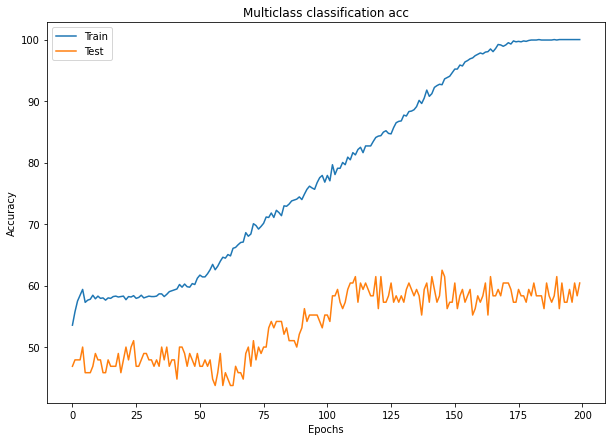

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Multiclass classification acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.legend(['Train','Test'])
plt.show()

# ResNet-18

In [ ]:
dat['stimuli'].shape

(1750, 128, 128)

In [ ]:
y2_train.shape,y2_test.shape

((1401, 1), (104, 1))

In [ ]:
y3_train.shape, y3_test.shape

((1750, 1), (120, 1))

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset(np.expand_dims(dat['stimuli'],1),y3_train),batch_size=16,shuffle=True,drop_last = True)
test_loader = torch.utils.data.DataLoader(test_dataset(np.expand_dims(dat['stimuli_test'],1),y3_test),batch_size=16,drop_last = True)

In [ ]:
model = torchvision.models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
# reset final fully connected layer
num_classes = 3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.conv1 = nn.Conv2d(1,64, kernel_size=7, stride=2, padding=3,bias=False)
                               
model.fc = nn.Linear(num_ftrs, num_classes)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

criterion = nn.CrossEntropyLoss()

In [ ]:
model.train()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

n_epochs=100

for epoch in range(n_epochs):
    count =1
    total=0
    train_correct=0
    train_loss = 0
    for x, y in train_loader:
        y=y.reshape(16,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
        
        loss = criterion(yhat, y)
        train_loss +=loss.item()
       
        train_loss_list.append(loss.item())
       
        model.train()
        optimizer.zero_grad()
       
        loss.backward()
      
        optimizer.step()

        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        train_correct += (pred == y).sum().item()
        count+=1

    train_loss /= count
    train_acc = 100 * train_correct / total
    train_acc_list.append(train_acc)

    if epoch%25==0:
      print(f'Train_acc : {round(train_acc,3)}')
      print(f'Train_loss : {round(train_loss,3)}')
    
    #############################################################
    #test
    total =0
    test_correct = 0
    test_loss =0
    test_acc=0
    count =1

    model.eval()
    with torch.no_grad():
      for x,y in test_loader:
        y=y.reshape(16,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
      
        loss = criterion(yhat, y)
        test_loss +=loss.item()
        
        test_loss_list.append(loss.item())
      
        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        test_correct += (pred == y).sum().item()
        count+=1
        
      test_loss /= count
      test_acc = 100 * test_correct / total
      test_acc_list.append(test_acc)

      if epoch%25==0:
        print(f'Test_acc : {round(test_acc,3)}')
        print(f'Test_loss : {round(test_loss,3)}') 

In [ ]:
plt.figure(figsize=(10,7))
plt.title('ResNet18 - 3classes')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.legend(['Train','Train'])
plt.show()

In [ ]:
import seaborn as sns
test_feature = torch.from_numpy(np.expand_dims(dat['stimuli'],1)).type(torch.FloatTensor).to(device)
y_pred = model(test_feature)
_, pred = torch.max(y_pred, 1)
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y3_test,pred.cpu().detach().numpy())

plt.figure(figsize=(10,10,))
# sns.heatmap(conf,  annot=True, xticklabels = np.unique(labels[0,:])[:2]
#             ,yticklabels = np.unique(labels[0,:])[:2])
sns.heatmap(conf,  annot=True,annot_kws={"size": 50},  xticklabels = ['Animal','Artifact','other']
            ,yticklabels = ['Animal','Artifact','other'])

2 classes

In [ ]:
data2.shape

(1401, 8428)

In [ ]:
model = torchvision.models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
# reset final fully connected layer
num_classes = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.conv1 = nn.Conv2d(1,64, kernel_size=7, stride=2, padding=3,bias=False)
                               
model.fc = nn.Linear(num_ftrs, num_classes)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

criterion = nn.CrossEntropyLoss()

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset(np.expand_dims(sti_data2,1),y2_train),batch_size=32,shuffle=True,drop_last = True)
test_loader = torch.utils.data.DataLoader(test_dataset(np.expand_dims(sti_val_data2,1),y2_test),batch_size=32,drop_last = True)
# train_loader = torch.utils.data.DataLoader(train_dataset(sti_data2,y2_train),batch_size=32,shuffle=True,drop_last = True)
# test_loader = torch.utils.data.DataLoader(test_dataset(sti_val_data2,y2_test),batch_size=32,drop_last = True)

In [ ]:
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

n_epochs=100

for epoch in range(n_epochs):
    count =1
    total=0
    train_correct=0
    train_loss = 0
    for x, y in train_loader:
        y=y.reshape(32,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
        
        loss = criterion(yhat, y)
        train_loss +=loss.item()
       
        train_loss_list.append(loss.item())
       
        model.train()
        optimizer.zero_grad()
       
        loss.backward()
      
        optimizer.step()

        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        train_correct += (pred == y).sum().item()
        count+=1

    train_loss /= count
    train_acc = 100 * train_correct / total
    train_acc_list.append(train_acc)

    if epoch%25==0:
      print(f'Train_acc : {round(train_acc,3)}')
      print(f'Train_loss : {round(train_loss,3)}')
    
    #############################################################
    #test
    total =0
    test_correct = 0
    test_loss =0
    test_acc=0
    count =1

    model.eval()
    with torch.no_grad():
      for x,y in test_loader:
        y=y.reshape(32,)
        x,y = x.to(device),y.to(device)
        yhat = model(x)
      
        loss = criterion(yhat, y)
        test_loss +=loss.item()
        
        test_loss_list.append(loss.item())
      
        total += yhat.size(0) #total output size
        _, pred = torch.max(yhat.data, 1)
        test_correct += (pred == y).sum().item()
        count+=1
        
      test_loss /= count
      test_acc = 100 * test_correct / total
      test_acc_list.append(test_acc)

      if epoch%25==0:
        print(f'Test_acc : {round(test_acc,3)}')
        print(f'Test_loss : {round(test_loss,3)}') 

Train_acc : 58.14
Train_loss : 0.669
Test_acc : 51.042
Test_loss : 0.526
Train_acc : 100.0
Train_loss : 0.0
Test_acc : 61.458
Test_loss : 0.991
Train_acc : 100.0
Train_loss : 0.001
Test_acc : 63.542
Test_loss : 1.382
Train_acc : 99.927
Train_loss : 0.002
Test_acc : 61.458
Test_loss : 1.591


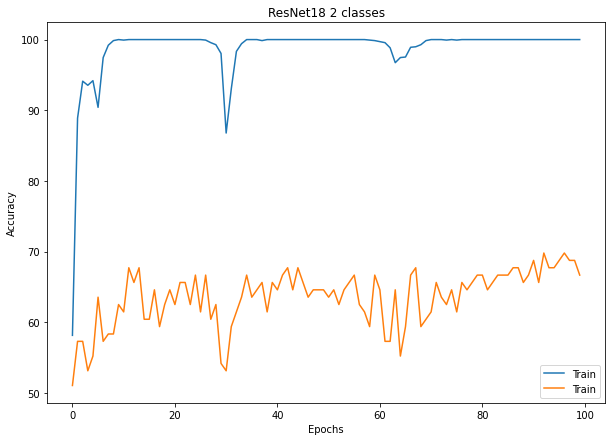

In [ ]:
plt.figure(figsize=(10,7))
plt.title('ResNet18 2 classes')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.legend(['Train','Train'])
plt.show()

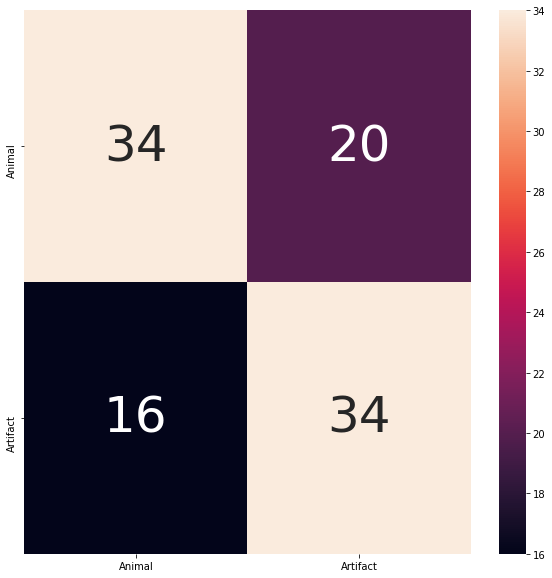

In [ ]:
import seaborn as sns
test_feature = torch.from_numpy(np.expand_dims(sti_val_data2,1)).type(torch.FloatTensor).to(device)
y_pred = model(test_feature)
_, pred = torch.max(y_pred, 1)
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y2_test,pred.cpu().detach().numpy())

plt.figure(figsize=(10,10,))
# sns.heatmap(conf,  annot=True, xticklabels = np.unique(labels[0,:])[:2]
#             ,yticklabels = np.unique(labels[0,:])[:2])
sns.heatmap(conf,  annot=True,annot_kws={"size": 50},  xticklabels = ['Animal','Artifact']
            ,yticklabels = ['Animal','Artifact'])